<a href="https://colab.research.google.com/github/nadyaloseva/Course_of_ML_itmo/blob/LinearRegression/Exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Всего датасет содержит 159 записей. Мы предварительно зарезервировали часть датасета для задания по преодолению бейслайна (baseline). В настоящем задании подразумевается работа с датасетом, содержащим 119 записей.

# 0. Применение полиномиальной регрессии для предсказания непрерывного параметра

Представленный набор данных — это набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Наша цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе. Сами признаки, быть может, нужно синтезировать из тех, что известны.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки с параметрами, указанными в вашем задании. Используйте стратификацию по колонке <code>Species</code>. Стратификация позволит сохранить доли представленных объектов (по представителям типов рыб) в тренировочной и тестовой выборках.

In [63]:
data= pd.read_csv('fish_train.csv')

In [89]:
# Предполагаем, что у нас есть DataFrame 'data' и целевая переменная 'Species'
x = data.drop(columns=['Species'])  # Признаки
y = data['Species']                  # Целевая переменная

# Разделение на тренировочный и тестовый наборы с стратификацией
x_train, X_test, y_train, Y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=23,
    stratify=y  # Указываем, что стратификация должна быть по целевой переменной
)

Вычислите выборочное среднее колонки <code>Width</code> полученной тренировочной выборки.

In [90]:
np.mean(x_train['Width'])

4.448602105263158

# 1. Построение базовой модели

Избавьтесь от категориальных признаков и обучите модель линейной регрессии (<code>LinearRegression()</code>) на тренировочном наборе данных. Выполните предсказания для тестового набора данных. Оцените модель при помощи метрики <code>r2_score()</code>.

In [91]:
# Преобразование категориальных признаков в x_train
y_train = pd.get_dummies(y_train, drop_first=True)
Y_test = pd.get_dummies(Y_test, drop_first=True)

In [92]:
# Модель линейной регрессии
reg = LinearRegression()

reg.fit(x_train, y_train)

# Предсказания на тренировочных данных
predictions = reg.predict(X_test)

# Оценка модели с помощью r2_score
r2_score(Y_test, predictions)

0.5249999494936023

# 2. Добавление предварительной обработки признаков.

## Использование PCA

При помощи, например, <code>sns.heatmap()</code>, постройте матрицу корреляций признаков тренировочного набора данных и определите тройку наиболее коррелированных между собой признаков.

<function matplotlib.pyplot.show(close=None, block=None)>

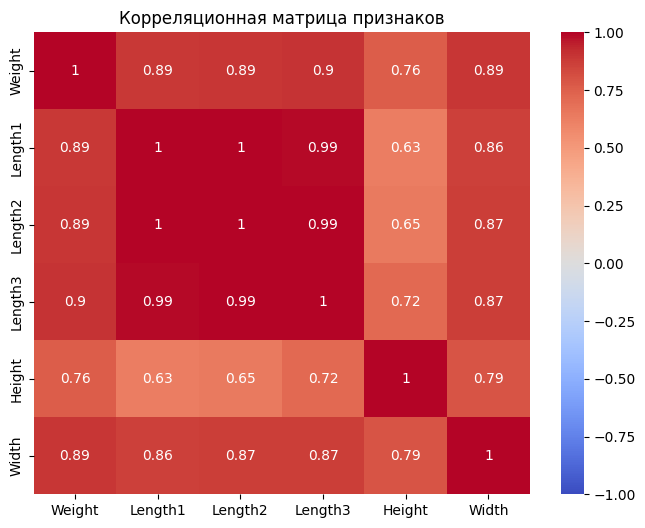

In [93]:
# Матрица ковариации
corr_matrix = x_train.corr()

#Строим heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица признаков')
plt.show


In [94]:
# Тройка пар наиболее коррелированных признаков

# Преобразовываем матрицу в таблицу
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending = False)

# Убираем корреляцию признаков с самыми собой
corr_pairs = corr_pairs[corr_pairs<1]

# Получаем топ 3
top_3 = corr_pairs.head(3)

In [95]:
top_3

,,0
Length2,Length1,0.999421
Length1,Length2,0.999421
Length3,Length2,0.993119


Линейные модели достаточно плохо реагируют на коррелированные признаки, поэтому от таких признаков имеет смысл избавиться еще до начала обучения.

Для уменьшения количества неинформативных измерений используйте метод главных компонент.

1) Примените метод главных компонент (<code>PCA(n_components=3, svd_solver='full')</code>) для трех найденных наиболее коррелированных признаков.

2) Вычислите долю объясненной дисперсии при использовании только первой главной компоненты.

3) Замените три наиболее коррелированных признака на новый признак <code>Lengths</code>, значения которого совпадают со значениями счетов первой главной компоненты.

In [96]:
# Применение PCA к трём наиболее коррелированным признакам
pca = PCA(n_components=3, svd_solver='full')
x_top_3 = x_train[['Length2', 'Length1', 'Length3']]
principal_comp = pca.fit_transform(x_top_3)

# Вычисление доли объясненной дисперсии при использовании только первой главной компоненты
explained_var = pca.explained_variance_ratio_[0]
print(f"Доля объяснённой дисперсии первой главной компонентой: {explained_var}")

# Заменяем три наиболее коррелированных признака на новый признак Lengths
x_train['Lengths'] = principal_comp[:, 0]
x_train = x_train.drop(columns=['Length2', 'Length1', 'Length3'])

Доля объяснённой дисперсии первой главной компонентой: 0.9960410310578471


Примените полученное преобразование для тех же признаков в тестовом наборе данных. Обратите внимание, что заново обучать преобразование `PCA` не нужно. Аналогично предыдущему этапу замените три рассмотренных признака на один.

In [97]:
# Применение уже обученного PCA к тестовому набору данных
x_top_3_test = X_test[['Length2', 'Length1', 'Length3']]

# Применяем transform вместо fit_transform, чтобы использовать обученную PCA
principal_comp_test = pca.transform(x_top_3_test)

# Заменяем три признака на новый 'Lengths'
X_test['Lengths'] = principal_comp_test[:, 0]
X_test = X_test.drop(columns=['Length2', 'Length1', 'Length3'])

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи <code>r2_score()</code>.

In [100]:
# Применяем one-hot encoding к тренировочным данным
y_train = pd.get_dummies(y_train, drop_first=True)
Y_test = pd.get_dummies(Y_test, drop_first=True)

reg = LinearRegression()

model = reg.fit(x_train,y_train)

# Прогнозирование на тестовых данных
predictions = reg.predict(X_test)

# Оценка модели с помощью r2_score
r2 = r2_score(Y_test, predictions)
print(f"R² score: {r2}")

R² score: 0.40156207077952133


Видно, что точность значительно не изменилась.

## Модификация признаков

Постройте графики зависимостей признаков от целевой переменной, например, при помощи <code>sns.pairplot()</code>.

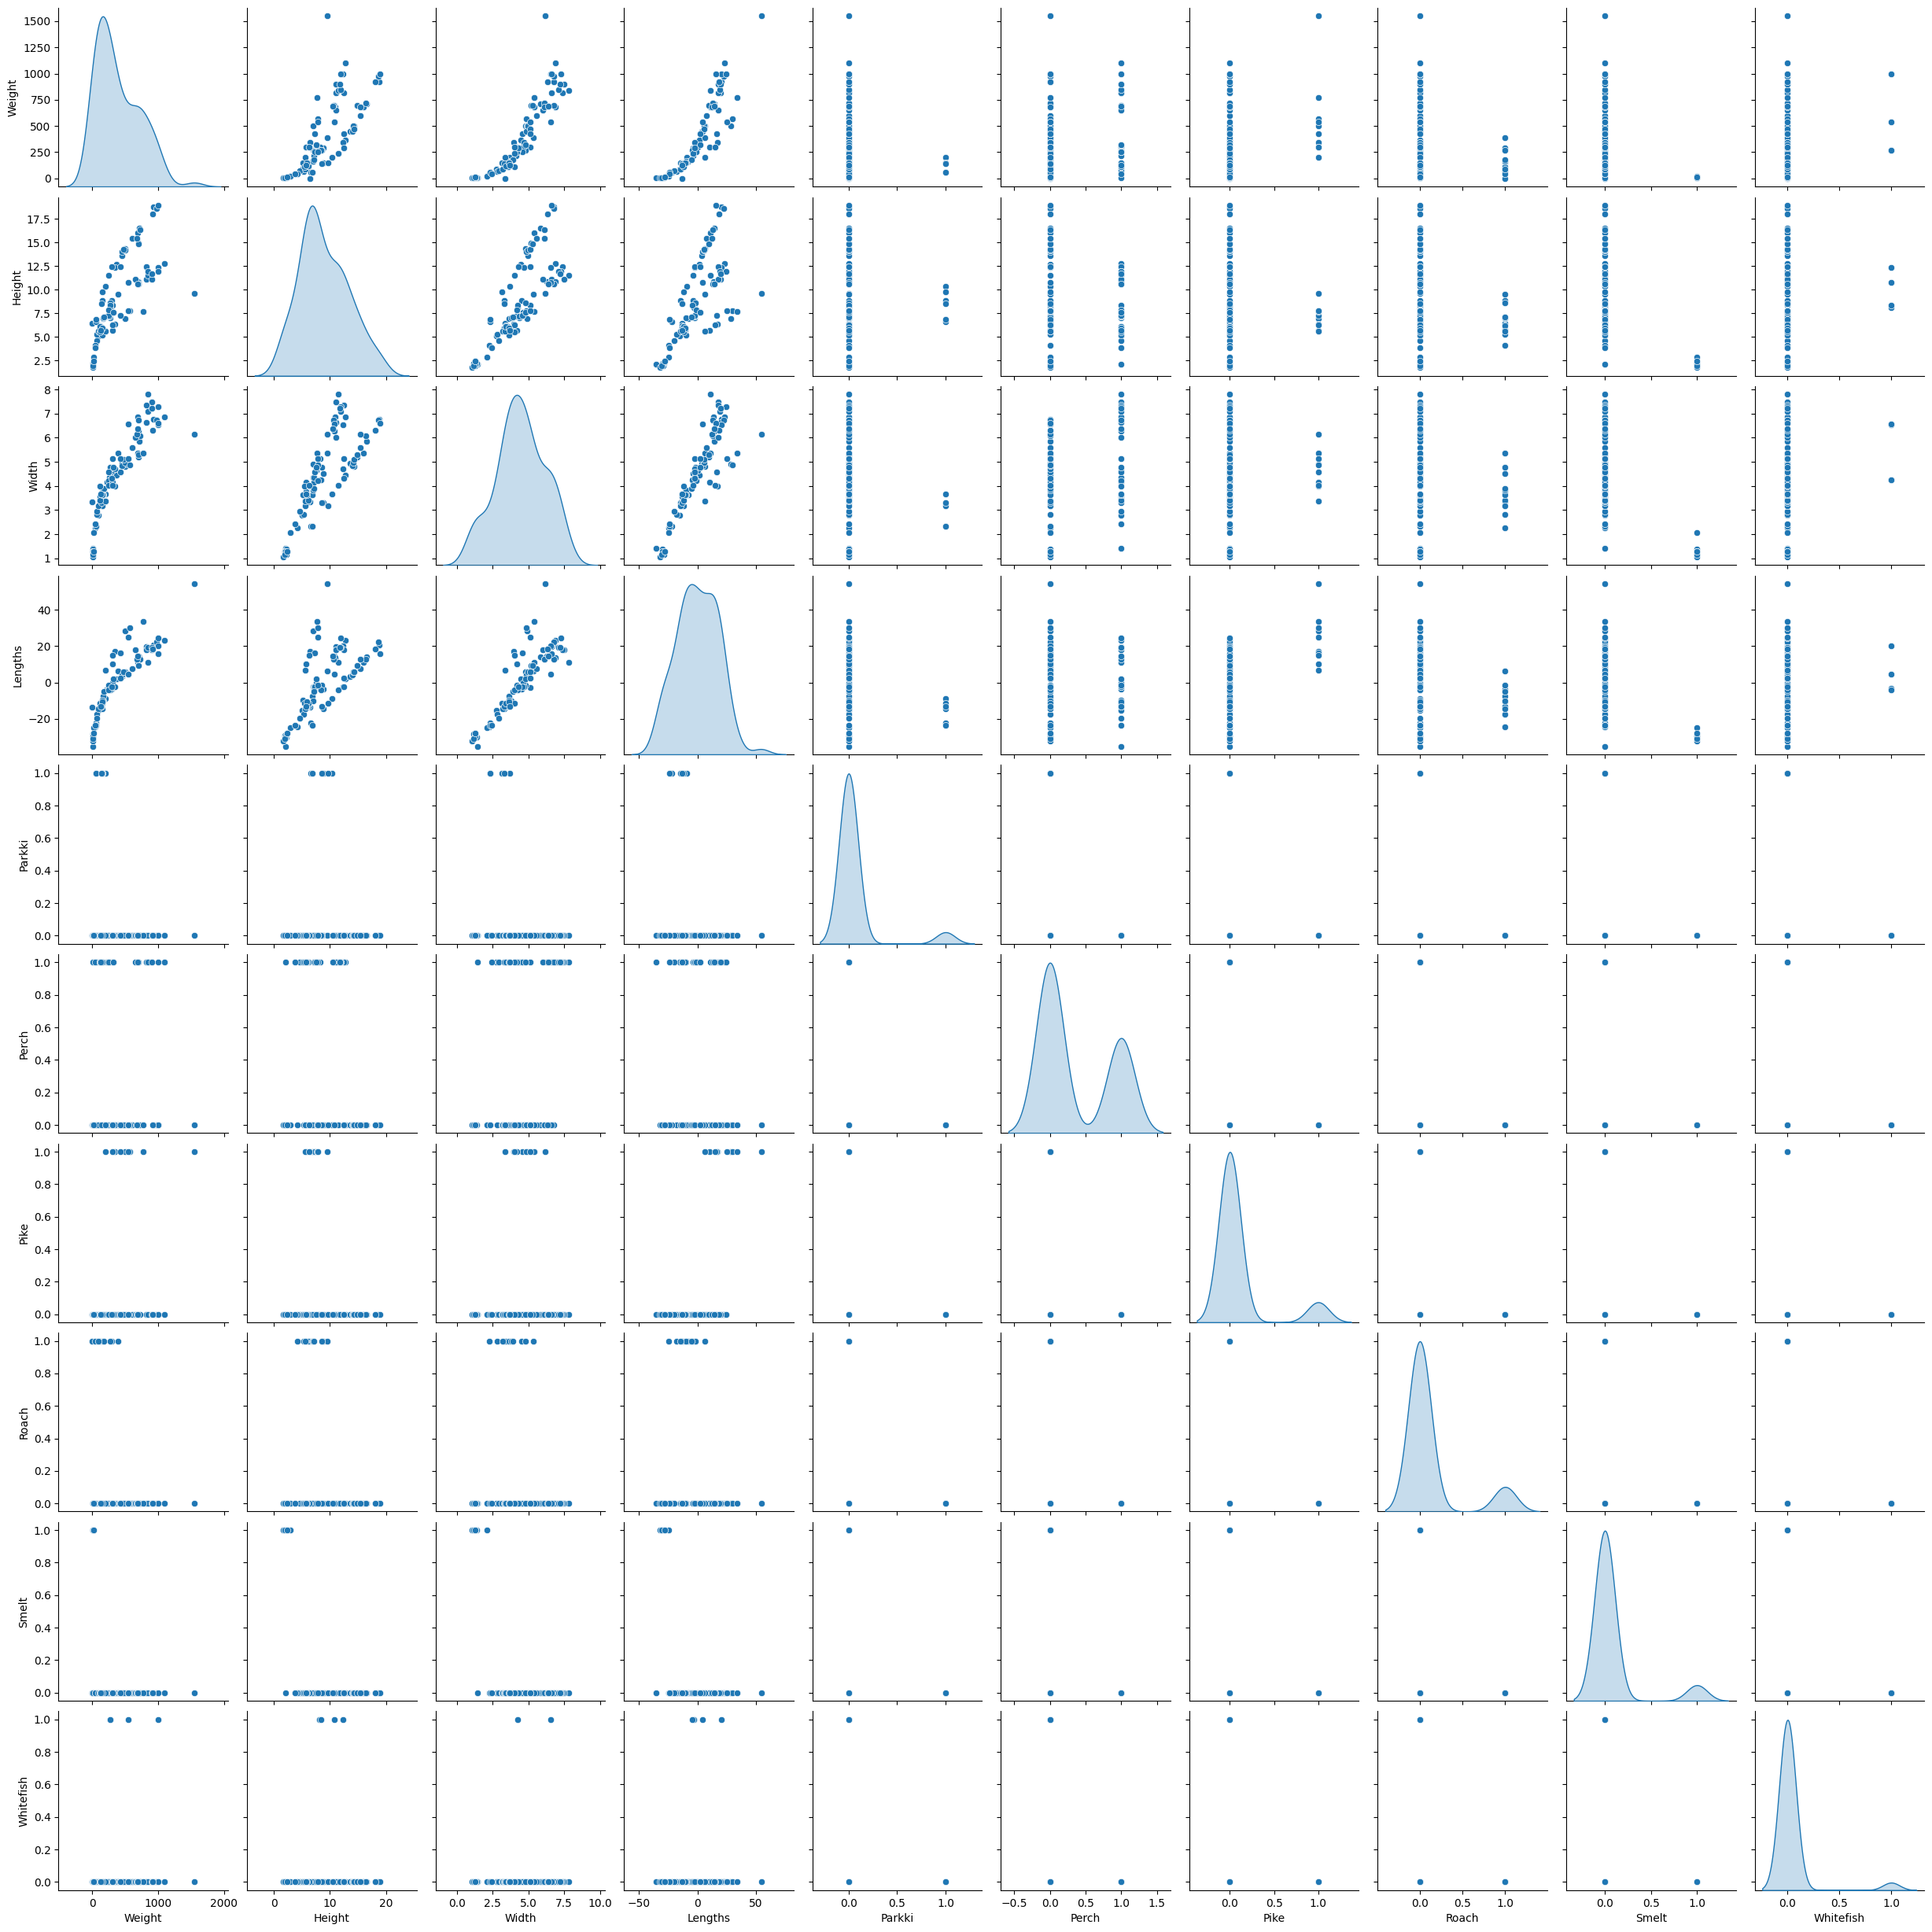

In [103]:
#y_train_series = pd.Series(y_train, name='Target')  # Задайте правильное имя целевой переменной

# Объединяем тренировочный набор данных с целевой переменной для построения pairplot
train_data = pd.concat([x_train, y_train], axis=1)

# Построение pairplot
sns.pairplot(train_data, diag_kind='kde')

plt.show()

Видно, что масса, вообще говоря, нелинейно зависит от остальных параметров. Значит, чтобы линейная модель хорошо справлялась с предсказанием, признаки имеет смысл преобразовать так, чтобы зависимость стала более похожей на линейную. Но как придумать такую зависимость?

Логично предположить, что масса рыбы должна каким-то гладким образом зависеть от остальных параметров, отвечающих так или иначе за размеры. Если впомнить, что масса — это произведение плотности на объем, то

$$
m = \rho \cdot V.
$$

Допустим, что средняя плотность у всех рыб одинаковая, и вспомним, что при гомотетии объем объекта зависит от линейных размеров как куб, тогда получим

$$
m\sim V\sim d^3
$$

Все признаки тренировочного и тестового наборов данных, отвечающие так или иначе за размеры (<code>Height, Width, Lengths</code>), возведите в третью степень, и проверьте, стала ли зависимость массы от этих признаков похожа на линейную.

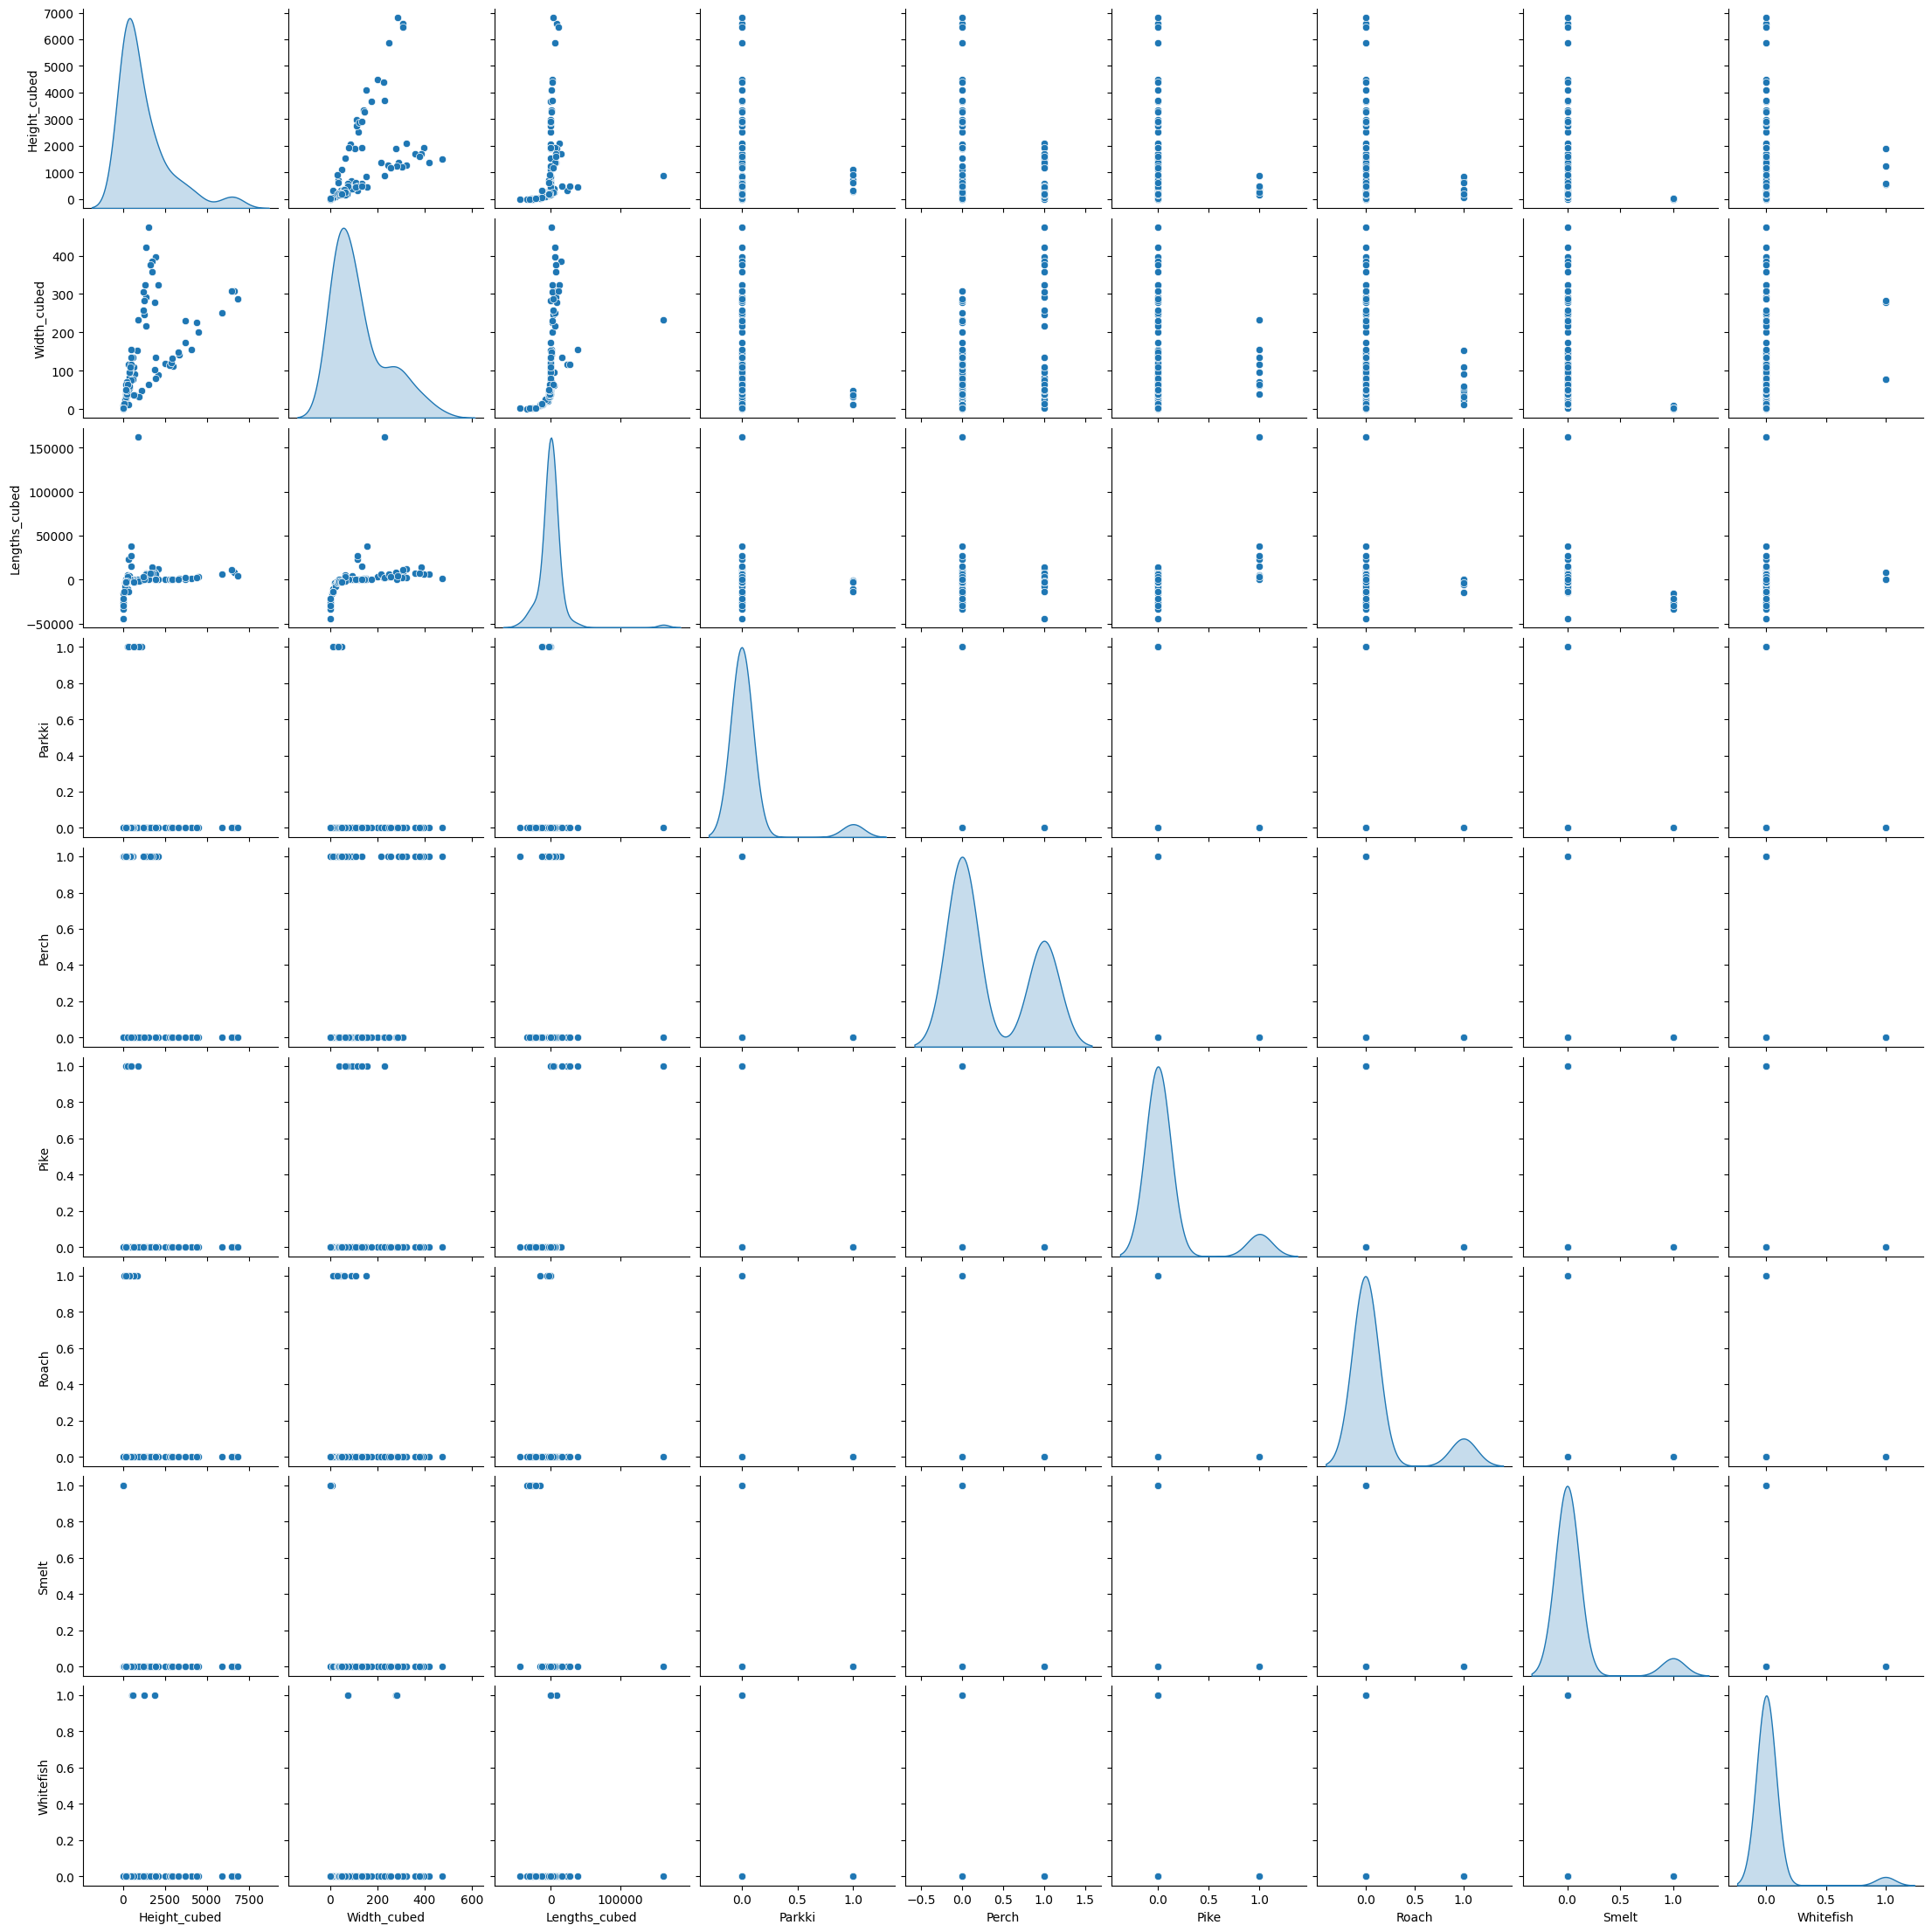

In [105]:
# Возводим признаки Height, Width и Lengths в третью степень для тренировочных данных
x_train['Height_cubed'] = np.power(x_train['Height'], 3)
x_train['Width_cubed'] = np.power(x_train['Width'], 3)
x_train['Lengths_cubed'] = np.power(x_train['Lengths'], 3)

# Для тестовых данных делаем то же самое
X_test['Height_cubed'] = np.power(X_test['Height'], 3)
X_test['Width_cubed'] = np.power(X_test['Width'], 3)
X_test['Lengths_cubed'] = np.power(X_test['Lengths'], 3)

# Построение графиков зависимости целевой переменной от преобразованных признаков
train_data_cubed = pd.concat([x_train[['Height_cubed', 'Width_cubed', 'Lengths_cubed']], y_train], axis=1)

# Построение pairplot для проверки линейности зависимости массы от преобразованных признаков
sns.pairplot(train_data_cubed, diag_kind='kde')

plt.show()

Text(0, 0.5, 'Weight (стандартизированный)')

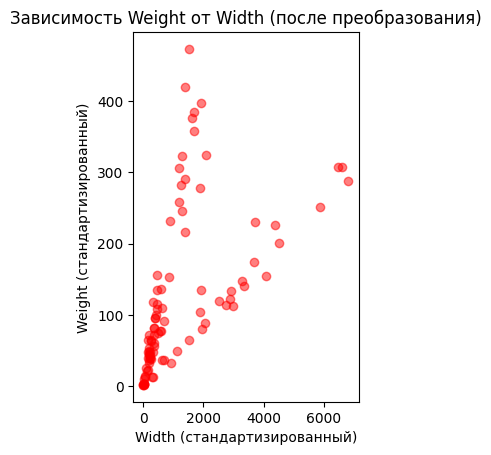

In [111]:
plt.subplot(1, 2, 2)
plt.scatter(train_data_cubed['Height_cubed'], train_data_cubed['Width_cubed'], color='red', alpha=0.5)
plt.title('Зависимость Weight от Width (после преобразования)')
plt.xlabel('Width (стандартизированный)')
plt.ylabel('Weight (стандартизированный)')

Введите выборочное среднее колонки <code>Width</code> тренировочного набора данных после возведения в куб.

In [106]:
X_test['Width_cubed'].mean()

146.78426471088872

Выберите изображения, соответствующие зависимости <code>Weight</code> от <code>Width</code> до преобразования и после.

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи `r2_score()`.

In [107]:
# Применяем one-hot encoding к тренировочным данным
y_train = pd.get_dummies(y_train)
Y_test = pd.get_dummies(Y_test)

reg = LinearRegression()

model = reg.fit(x_train,y_train)

# Прогнозирование на тестовых данных
predictions = reg.predict(X_test)

# Оценка модели с помощью r2_score
r2 = r2_score(Y_test, predictions)
print(f"R² score: {r2}")

R² score: 0.4707780906548355


Обратите внимание на то, как такая нехитрая работа с признаками помогла разительно улучшить точность модели!

## Добавление категориальных признаков

Произведите <code>one-hot</code> кодировние категориального признака `Species`, например, с помощью <code>pd.get_dummies()</code>.

Обучите модель линейной регресси на полученных тренировочных данных. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

<b>Примечание</b>: Мы специально использовали стратифицированное разделение, чтобы все значения категориального признака <code>Species</code> присутствовали во всех наборах данных. Но такое возможно не всегда. Про то, как с этим бороться можно почитать, [например, здесь](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

In [115]:
x_train = x_train[['Height_cubed','Width_cubed',	'Lengths_cubed']]
X_test = X_test[['Height_cubed','Width_cubed',	'Lengths_cubed']]

In [116]:
# Применяем one-hot encoding к тренировочным данным
y_train = pd.get_dummies(y_train)
Y_test = pd.get_dummies(Y_test)

reg = LinearRegression()

model = reg.fit(x_train,y_train)

# Прогнозирование на тестовых данных
predictions = reg.predict(X_test)

# Оценка модели с помощью r2_score
r2 = r2_score(Y_test, predictions)
print(f"R² score: {r2}")

R² score: 0.19664186039568757


И снова точность возрасла.

Как можно увидеть, после `one-hot` кодирования признаки стали коррелированы. От этого можно избавиться, например, при помощи параметра `drop_first=True`. Заново обучите модель после исправления этого недочета. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

In [110]:
# Применяем one-hot encoding к тренировочным данным
y_train = pd.get_dummies(y_train, drop_first=True)
Y_test = pd.get_dummies(Y_test, drop_first=True)

reg = LinearRegression()

model = reg.fit(x_train,y_train)

# Прогнозирование на тестовых данных
predictions = reg.predict(X_test)

# Оценка модели с помощью r2_score
r2 = r2_score(Y_test, predictions)
print(f"R² score: {r2}")

R² score: 0.4707780906548355


На таком сравнительно небольшом наборе данных, впрочем, разницы мы не видим.